In [1]:
import utils

In [2]:
from src.NN.KerasMultiHead import MultiHeadModel
from src.Data.IMULocationDataset import IMULocationDataset
from src.Data.MergedIMULocationDataset import MergedIMULocationDataset
from whar_datasets import WHARDatasetID
from src.NN.Arch.ClassifierHead import *
from src.NN.Arch.ReconstructionHead import *
from src.NN.Arch.Encoder import *
from src.Data.SensorTypes import SensorLocation

import numpy as np

2026-01-10 13:47:42.413075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/king/Github/TinyHARFoundation/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


++++++ Global class name mapping:
0: Stand-sit
1: car_driving
2: clean_table
3: close_dishwasher
4: close_door
5: close_drawer
6: close_fridge
7: computer_work
8: cycling
9: cycling_on_exercise_bike_horizontal
10: cycling_on_exercise_bike_vertical
11: drinking
12: exercise_cross_trainer
13: exercise_stepper
14: folding_laundry
15: frontal_elevation_of_arms
16: house_cleaning
17: ironing
18: jogging
19: jump_front_and_back
20: jumping
21: knees_bending_crouching
22: laying
23: laying_standing
24: moving_around_in_an_elevator
25: nordic_walking
26: null
27: open_dishwasher
28: open_door
29: open_drawer
30: open_fridge
31: picking
32: playing_basketball
33: playing_soccer
34: push_up
35: rope_jumping
36: rowing
37: running
38: running_threadmill
39: sit_up
40: sitting
41: stair_down
42: stair_up
43: standing
44: standing_in_an_elevator_still
45: table_tennis
46: talking_sitting
47: talking_standing
48: toggle_switch
49: unknown
50: vacuum_cleaning
51: waist_bends_forward
52: walking
53: w

In [ ]:
mhealth = IMULocationDataset(WHARDatasetID.MHEALTH)
dsads = IMULocationDataset(WHARDatasetID.DSADS)
pamap2 = IMULocationDataset(WHARDatasetID.PAMAP2)

Loaded IMU Location Dataset from cache.
Loaded IMU Location Dataset from cache.
Loaded IMU Location Dataset from cache.


In [43]:
uci_har = IMULocationDataset(WHARDatasetID.UCI_HAR)

2026-01-10 15:00:14,777 - whar-datasets - INFO - Running DownloadingStep
2026-01-10 15:00:14,778 - whar-datasets - INFO - Checking hash for DownloadingStep
/home/king/Github/TinyHARFoundation/.venv/lib/python3.11/site-packages/pydantic/main.py:477: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `PosixPath` with value `PosixPath('/home/king/Git...on/cache/whar_datasets')` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_json(
2026-01-10 15:00:14,782 - whar-datasets - INFO - Hash is not up to date
2026-01-10 15:00:14,782 - whar-datasets - INFO - Downloading uci_har
2026-01-10 15:00:21,842 - whar-datasets - INFO - Extracting uci_har
2026-01-10 15:00:24,425 - whar-datasets - INFO - Running ParsingStep
2026-01-10 15:00:24,426 - whar-datasets - INFO - Checking hash for ParsingStep
2026-01-10 15:00:24,426 - whar-datasets - INFO - Hash is not up to date
2026-01-10 15:00:24,427 - whar-datasets - INFO - Checking download
2026-01-10 15:00:24,

In [49]:
merged_dataset = MergedIMULocationDataset([uci_har], locations=[SensorLocation.HIP])
print(merged_dataset.train.samples.shape, merged_dataset.train.labels.shape)

(7124, 128, 9) (7124,)


In [53]:
from keras.models import Model
import tensorflow as tf
from keras import layers as L
ds_slice = merged_dataset.train.samples[0:1]  # For testing shapes
print("Input shape:", ds_slice.shape)

backbone = build_conv_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
classifier_head = build_classifier_head(num_classes=merged_dataset.num_classes, channels=backbone.output_shape[-1])
backbone(ds_slice).shape
print("Backbone parameters:", backbone.count_params())
print("Classifier head parameters:", classifier_head.count_params())

multi_head = MultiHeadModel(backbone)
multi_head.add_head("classifier", classifier_head)
multi_head(ds_slice)["classifier"].shape

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={"classifier": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]},
)

history = multi_head.fit(x=merged_dataset.train.samples, y={"classifier": merged_dataset.train.labels}, epochs=20, verbose=1)

test_results = multi_head.evaluate(
    x=merged_dataset.test.samples,
    y={"classifier": merged_dataset.test.labels},
    verbose=1,
)
print("Test results:", test_results)

Input shape: (1, 128, 9)
Backbone parameters: 78642
Classifier head parameters: 3835
Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 34s 69ms/step - acc: 0.5347 - loss: 1.3007
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7301 - loss: 0.6674
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7777 - loss: 0.5670
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.7970 - loss: 0.5259
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8134 - loss: 0.4719
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8171 - loss: 0.4546
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8245 - loss: 0.4404
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8345 - loss: 0.4186
Epoch 9/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8419 - loss: 0.4025
Epoch 10/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.8467 - loss: 0.3875
Epoch 11/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - acc: 0.8504 - loss: 0.3823
Epoch 12/20
223/223 

In [7]:
# def build_classifier_head(num_classes):
#     z_in = tf.keras.Input(shape=(128,), name="embedding")
#     x = L.Dense(64, activation="swish", name="clf_dense1")(z_in)
#     x = L.Dropout(0.3, name="clf_do1")(x)
#     x = L.Dense(num_classes, activation="softmax", name="clf_out")(x)
#     return tf.keras.Model(z_in, x, name="classifier_head")

# classifier_head = build_classifier_head(num_classes=dataset.num_classes)

In [54]:
from src.Data.Preprocessing import make_masked_reconstruction_ds

# backbone = build_conv_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
backbone = build_conv_backbone_seq(ts_len=merged_dataset.train.samples.shape[1])
reconstruction_head = build_reconstruction_head()
multi_head = MultiHeadModel(backbone)
multi_head.add_head("reconstruction", reconstruction_head)

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss={"reconstruction": tf.keras.losses.MeanSquaredError()},
)

train_ds = make_masked_reconstruction_ds(merged_dataset.train.samples, batch_size=64, mask_ratio=0.2)
val_ds   = make_masked_reconstruction_ds(merged_dataset.val.samples,   batch_size=64, mask_ratio=0.2, shuffle=0)

multi_head.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - loss: 0.1918 - val_loss: 0.1450
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1381 - val_loss: 0.1332
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1286 - val_loss: 0.1286
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1256 - val_loss: 0.1230
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1224 - val_loss: 0.1213
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1201 - val_loss: 0.1197
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1195 - val_loss: 0.1175
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1183 - val_loss: 0.1157
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1171 - val_loss: 0.1155
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1167 - val_loss: 0.1143
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1167 - val_loss: 0.1139
Epoch 12/20
112/112 ━━━━━━━━━━━━━━━━━━━

In [55]:
multi_head.backbone.save("pretrained_backbone.keras")

In [ ]:
fine_tune_dataset = MergedIMULocationDataset([uci_har], locations=[SensorLocation.ARMS], ratio=0.05)

In [59]:
import keras

classifier_head = build_classifier_head(
    num_classes=merged_dataset.num_classes,
    channels=multi_head.backbone.output_shape[-1],
)

multi_head = MultiHeadModel(keras.models.load_model("pretrained_backbone.keras"))
#multi_head = MultiHeadModel(keras.models.load_model("pretrained_contrastive_backbone.keras"))


multi_head.add_head("classifier", classifier_head)
multi_head.backbone.trainable = False

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={"classifier": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]},
)

history = multi_head.fit(
    x=fine_tune_dataset.train.samples,
    y={"classifier": fine_tune_dataset.train.labels},
    validation_data=(fine_tune_dataset.val.samples, {"classifier": fine_tune_dataset.val.labels}),
    epochs=20,
    verbose=1,
)

# Now evaluate on test set
test_results = multi_head.evaluate(
    x=fine_tune_dataset.test.samples,
    y={"classifier": fine_tune_dataset.test.labels},
    verbose=1,
)

print("Test results:", test_results)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - acc: 0.0332 - loss: 4.9249 - val_acc: 0.0316 - val_loss: 4.5616
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.0418 - loss: 4.2620 - val_acc: 0.0422 - val_loss: 3.9293
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.0808 - loss: 3.6605 - val_acc: 0.0646 - val_loss: 3.3545
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.1573 - loss: 3.1406 - val_acc: 0.3962 - val_loss: 2.8273
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.4401 - loss: 2.6676 - val_acc: 0.6376 - val_loss: 2.3582
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.6075 - loss: 2.2377 - val_acc: 0.6854 - val_loss: 1.9705
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.6739 - loss: 1.9046 - val_acc: 0.7086 - val_loss: 1.6797
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - acc: 0.6869 - loss: 1.6735 - val_acc: 0.7197 - val_loss: 1.4969
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - acc: 0.69

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
(5000, 64)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.381686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.760086
[t-SNE] KL divergence after 1000 iterations: 2.021735


(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Backbone embeddings (train)'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>)

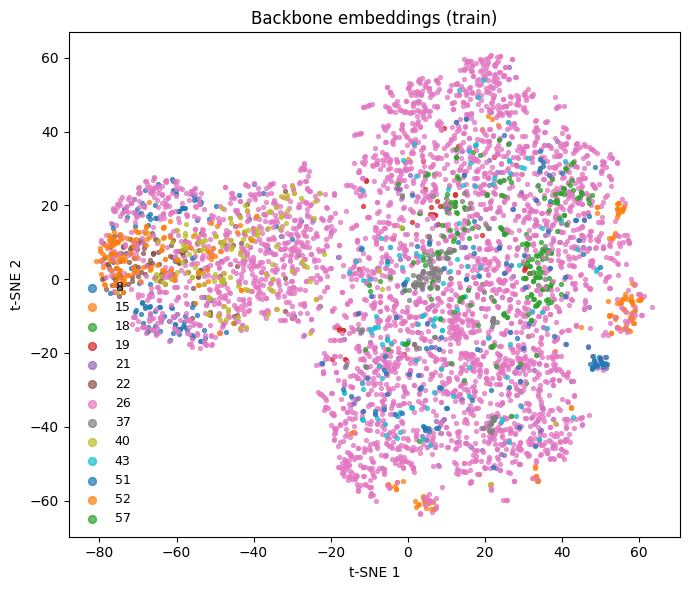

In [12]:
from src.Visualization.tsne import tsne, plot_tsne
import numpy as np
import keras
backbone = keras.models.load_model("pretrained_backbone.keras")

num_samples = 5000
indices = np.random.choice(merged_dataset.train.samples.shape[0], num_samples, replace=False)
sampled_samples = merged_dataset.train.samples[indices]
sampled_labels = merged_dataset.train.labels[indices]
feat = backbone.predict(sampled_samples, batch_size=32, verbose=1)   # (N,T,C)
E = feat.mean(axis=1)
print(E.shape)

res = tsne(E, perplexity=30, random_state=0)
plot_tsne(res.xy, labels=sampled_labels, title="Backbone embeddings (train)")

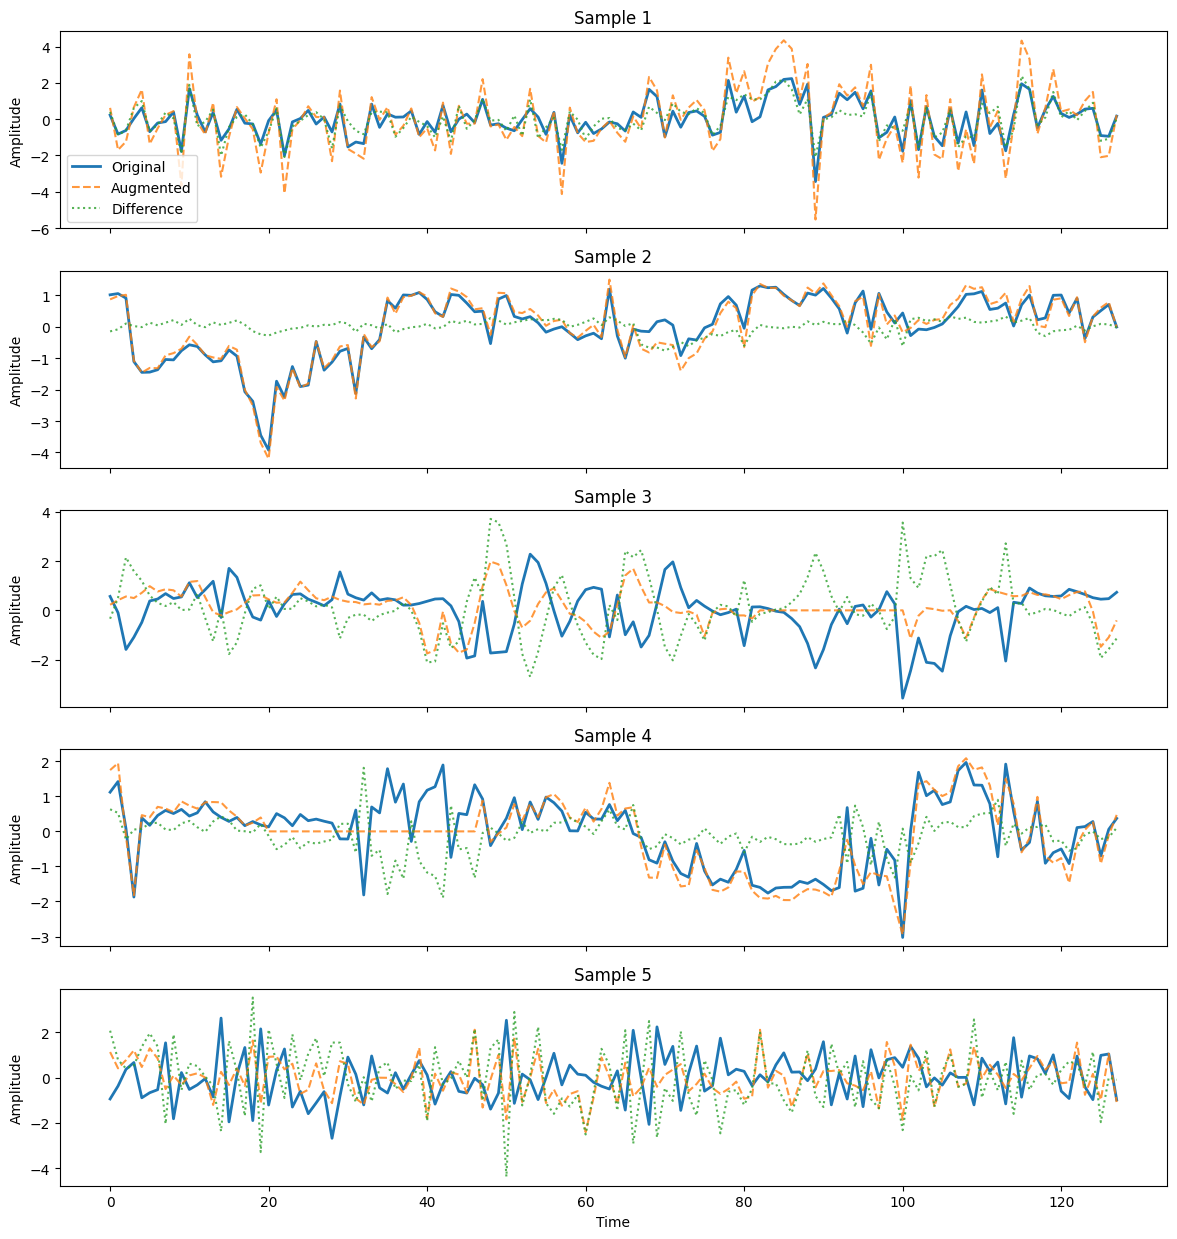

diff: 4.9612355


In [18]:
from src.Data.InertialAugmentRandomCombo import InertialAugmentRandomCombo, AugConfig


cfg = AugConfig(
    probs={"scale": 1.0, "jitter": 1.0, "time_shift": 0.8, "time_mask": 0.8, "resample": 0.8, "rotate": 0.5},
    min_ops=2,
    max_ops=5,
    jitter_std=0.08,
    scale_jitter=0.5,
    time_mask_ratio=0.15,
    max_time_shift=50,
    resample_min_factor=0.7,
    resample_max_factor=1.3,
    max_rotate_deg=30.0,
    randomize_params=True,
    param_jitter=0.5,
)

augmenter = InertialAugmentRandomCombo(cfg)

samples = merged_dataset.train.samples[0:5]
samples = np.expand_dims(samples, axis=1)

augmented_samples = augmenter(samples)


import matplotlib.pyplot as plt

num_samples = 5

fig, axes = plt.subplots(
    nrows=num_samples,
    ncols=1,
    figsize=(12, 2.5 * num_samples),
    sharex=True
)

for i in range(num_samples):
    axes[i].plot(
        samples[i, 0, :, 0],
        label="Original",
        linewidth=2
    )

    axes[i].plot(
        augmented_samples[i, 0, :, 0],
        label="Augmented",
        linestyle="--",
        alpha=0.8
    )

    axes[i].plot(
        augmented_samples[i, 0, :, 0] - samples[i, 0, :, 0],
        label="Difference",
        linestyle=":",
        alpha=0.8
    )

    axes[i].set_title(f"Sample {i+1}")
    axes[i].set_ylabel("Amplitude")

    # show legend only once
    if i == 0:
        axes[i].legend()

axes[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()


print("diff:", np.max(np.abs(samples - augmented_samples)))

In [14]:
from src.Data.Preprocessing import make_contrastive_ds
from src.Data.InertialAugmentRandomCombo import InertialAugmentRandomCombo, AugConfig
from src.NN.Arch import (
    build_transformer_backbone_seq,
    build_two_view_backbone_seq,
    build_contrastive_head,
)
from src.NN.KerasMultiHead import MultiHeadModel
from src.NN.Losses import InfoNCELoss
import tensorflow as tf


merged_dataset = MergedIMULocationDataset([mhealth], locations=[SensorLocation.ARMS])

ts_len = merged_dataset.train.samples.shape[1]

cfg = AugConfig(
    probs={"scale": 1.0, "jitter": 1.0, "time_shift": 0.8, "time_mask": 0.8, "resample": 0.8, "rotate": 0.5},
    min_ops=2,
    max_ops=5,
    jitter_std=0.08,
    scale_jitter=0.5,
    time_mask_ratio=0.15,
    max_time_shift=50,
    resample_min_factor=0.7,
    resample_max_factor=1.3,
    max_rotate_deg=30.0,
    randomize_params=True,
    param_jitter=0.5,
)


augmenter = InertialAugmentRandomCombo(cfg)

base_backbone = build_transformer_backbone_seq(ts_len=ts_len)
backbone = build_two_view_backbone_seq(base_backbone, ts_len=ts_len)

proj_dim = 128
contrastive_head = build_contrastive_head(proj_dim=proj_dim)

multi_head = MultiHeadModel(backbone)
multi_head.add_head("contrastive", contrastive_head)

multi_head.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0),
    loss={"contrastive": InfoNCELoss(temperature=0.5)},
)

train_ds = make_contrastive_ds(merged_dataset.train.samples, batch_size=256, proj_dim=proj_dim, augmenter=augmenter)
val_ds   = make_contrastive_ds(merged_dataset.val.samples,   batch_size=256, proj_dim=proj_dim, augmenter=augmenter, shuffle=0)


class SimCallback(tf.keras.callbacks.Callback):
    def __init__(self, ds, batches=5): self.ds, self.batches = ds, batches
    def on_epoch_end(self, epoch, logs=None):
        pos_sims, neg_sims = [], []
        for i, (x, _) in enumerate(self.ds.take(self.batches)):
            z = self.model(x, training=False)["contrastive"]  # (B,2,D)
            z1, z2 = z[:,0,:], z[:,1,:]
            pos = tf.reduce_sum(z1 * z2, axis=-1)  # cosine (unit-normalized)
            neg = tf.matmul(z1, z2, transpose_b=True)  # (B,B)
            neg = tf.boolean_mask(neg, ~tf.eye(tf.shape(neg)[0], dtype=tf.bool))
            pos_sims.append(tf.reduce_mean(pos)); neg_sims.append(tf.reduce_mean(neg))
        print(f"epoch {epoch+1}: pos_cos={tf.reduce_mean(pos_sims):.3f} neg_cos={tf.reduce_mean(neg_sims):.3f}")



multi_head.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1, callbacks=[SimCallback(val_ds)])


Epoch 1/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 5.2457

2026-01-10 13:52:15.693472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion', 12 bytes spill stores, 12 bytes spill loads



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - loss: 5.2409epoch 1: pos_cos=0.916 neg_cos=0.096
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - loss: 4.9814 - val_loss: 4.8156
Epoch 2/20


2026-01-10 13:52:28.673481: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 4.7621epoch 2: pos_cos=0.930 neg_cos=0.006
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 611ms/step - loss: 4.7386 - val_loss: 4.6370
Epoch 3/20


2026-01-10 13:53:02.268293: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - loss: 4.7048epoch 3: pos_cos=0.933 neg_cos=0.008
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 631ms/step - loss: 4.6874 - val_loss: 4.6103
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 4.6741epoch 4: pos_cos=0.932 neg_cos=0.002
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 691ms/step - loss: 4.6638 - val_loss: 4.5882
Epoch 5/20


2026-01-10 13:54:15.038254: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 4.6545epoch 5: pos_cos=0.938 neg_cos=0.002
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - loss: 4.6440 - val_loss: 4.5725
Epoch 6/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 4.6395epoch 6: pos_cos=0.938 neg_cos=0.003
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 721ms/step - loss: 4.6282 - val_loss: 4.5666
Epoch 7/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - loss: 4.6242epoch 7: pos_cos=0.936 neg_cos=0.005
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 642ms/step - loss: 4.6154 - val_loss: 4.5516
Epoch 8/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 4.6103epoch 8: pos_cos=0.941 neg_cos=0.004
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 637ms/step - loss: 4.6035 - val_loss: 4.5471
Epoch 9/20


2026-01-10 13:56:39.371521: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - loss: 4.5998epoch 9: pos_cos=0.939 neg_cos=0.008
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 643ms/step - loss: 4.5926 - val_loss: 4.5396
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 4.5952epoch 10: pos_cos=0.943 neg_cos=0.007
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 672ms/step - loss: 4.5874 - val_loss: 4.5312
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 4.5902epoch 11: pos_cos=0.945 neg_cos=0.004
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 663ms/step - loss: 4.5826 - val_loss: 4.5255
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 4.5805epoch 12: pos_cos=0.946 neg_cos=0.005
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 651ms/step - loss: 4.5729 - val_loss: 4.5188
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 4.5771epoch 13: pos_cos=0.946 neg_cos=0.007
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 704ms/step - loss: 4.5680 - val_loss: 4.5175
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 4.5724epoch 14: pos_cos=0.942 neg_cos=0.003
55/

2026-01-10 14:01:31.419342: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 4.5622epoch 17: pos_cos=0.944 neg_cos=0.009
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 610ms/step - loss: 4.5542 - val_loss: 4.5083
Epoch 18/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 4.5542epoch 18: pos_cos=0.946 neg_cos=0.005
55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 683ms/step - loss: 4.5505 - val_loss: 4.5001
Epoch 19/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - loss: 4.5520epoch 19: pos_cos=0.947 neg_cos=0.006
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 661ms/step - loss: 4.5441 - val_loss: 4.4997
Epoch 20/20
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 4.5511epoch 20: pos_cos=0.942 neg_cos=0.009
55/55 ━━━━━━━━━━━━━━━━━━━━ 37s 680ms/step - loss: 4.5437 - val_loss: 4.5018


In [15]:
base_backbone.save("pretrained_contrastive_backbone.keras")

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
(5000, 64)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.385660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.698959
[t-SNE] KL divergence after 1000 iterations: 2.028795


(<Figure size 700x600 with 1 Axes>,
 <Axes: title={'center': 'Backbone embeddings (train)'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>)

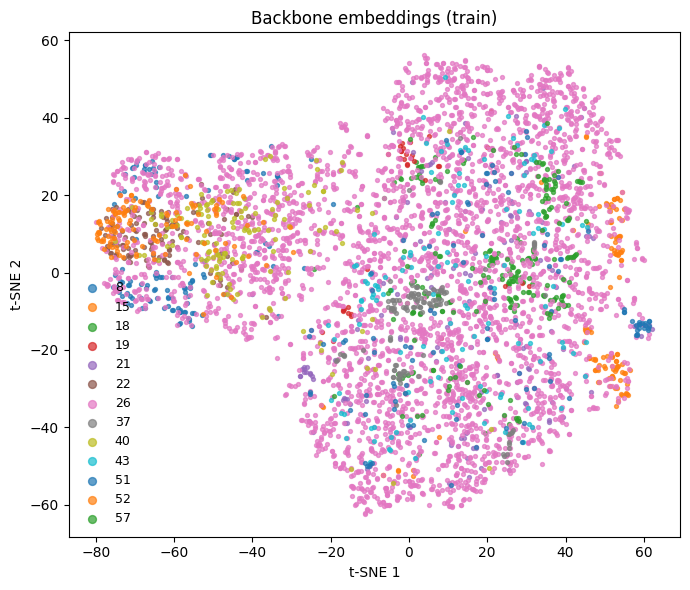

In [42]:
from src.Visualization.tsne import tsne, plot_tsne
import numpy as np
import keras
backbone = keras.models.load_model("pretrained_backbone.keras")

num_samples = 5000
indices = np.random.choice(merged_dataset.train.samples.shape[0], num_samples, replace=False)
sampled_samples = merged_dataset.train.samples[indices]
sampled_labels = merged_dataset.train.labels[indices]
feat = backbone.predict(sampled_samples, batch_size=32, verbose=1)   # (N,T,C)
E = feat.mean(axis=1)
print(E.shape)

res = tsne(E, perplexity=30, random_state=0)
plot_tsne(res.xy, labels=sampled_labels, title="Backbone embeddings (train)")